In [1]:
import numpy as np
import itertools
import warnings
import matplotlib.pyplot as plt

In [2]:
import tenpy

from tenpy.networks.site import Site, SpinHalfFermionSite, SpinHalfSite, GroupedSite, SpinSite
from tenpy.tools.misc import to_iterable, to_iterable_of_len, inverse_permutation
from tenpy.networks.mps import MPS  # only to check boundary conditions

from tenpy.models.lattice import Lattice, _parse_sites
from tenpy.models.model import CouplingMPOModel, NearestNeighborModel
from tenpy.tools.params import get_parameter

from tenpy.algorithms import dmrg

In [3]:
__all__ = ['KitaevLadder', 'KitaevLadderModel']

In [4]:
class KitaevLadder(Lattice):    
    """ A ladder coupling two chains of the Kitaev form
    .. image :: /images/lattices/Ladder.*
    Parameters
    ----------
    L : int
        The length of each chain, we have 2*L sites in total.
    sites : (list of) :class:`~tenpy.networks.site.Site`
        The two local lattice sites making the `unit_cell` of the :class:`Lattice`.
        If only a single :class:`~tenpy.networks.site.Site` is given, it is used for both chains.
    **kwargs :
        Additional keyword arguments given to the :class:`Lattice`.
        `basis`, `pos` and `pairs` are set accordingly.
    """
    dim = 1

    def __init__(self, L, sites, **kwargs):
        sites = _parse_sites(sites, 4)
        basis = np.array([[2., 0.]])
        pos = np.array([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
        kwargs.setdefault('basis', basis)
        kwargs.setdefault('positions', pos)
        kwargs.setdefault('bc', 'periodic')
        kwargs.setdefault('bc_MPS', 'infinite')
        NNz = [(0, 1, np.array([0])), (2, 3, np.array([0]))]
        NNx = [(1, 3, np.array([0])), (2, 0, np.array([1]))]
        NNy = [(0, 2, np.array([0])), (3, 1, np.array([1]))]
        kwargs.setdefault('pairs', {})
        kwargs['pairs'].setdefault('nearest_neighbors_x', NNx)
        kwargs['pairs'].setdefault('nearest_neighbors_y', NNy)
        kwargs['pairs'].setdefault('nearest_neighbors_z', NNz)
        Lattice.__init__(self, [L], sites, **kwargs)
        
        
class KitaevLadderModel(CouplingMPOModel):
    def __init__(self, model_params):
        CouplingMPOModel.__init__(self, model_params)

    def init_sites(self, model_params):
        conserve = get_parameter(model_params, 'conserve', None, self.name)
        fs = SpinHalfSite(conserve=conserve)
        return [fs, fs, fs, fs]

    def init_lattice(self, model_params):
        L = get_parameter(model_params, 'L', 3, self.name)
        gs = self.init_sites(model_params)
        model_params.pop("L")
        lat = KitaevLadder(L, gs)
        return lat

    def init_terms(self, model_params):
        Jx = get_parameter(model_params, 'Jx', 1., self.name, True)
        Jy = get_parameter(model_params, 'Jy', 1., self.name, True)
        Jz = get_parameter(model_params, 'Jz', 1., self.name, True)

        for u1, u2, dx in self.lat.pairs['nearest_neighbors_z']:
            self.add_coupling(-Jz, u1, 'Sx', u2, 'Sx', dx)
        for u1, u2, dx in self.lat.pairs['nearest_neighbors_x']:
            self.add_coupling(-Jx, u1, 'Sz', u2, 'Sz', dx)
        for u1, u2, dx in self.lat.pairs['nearest_neighbors_y']:
            self.add_coupling(-Jy, u1, 'Sy', u2, 'Sy', dx)
         
        
def plot_lattice():
    fig, ax = plt.subplots()
    lat = KitaevLadder(5, None, bc='periodic')
    links_name = 'nearest_neighbors_z'
    lat.plot_coupling(ax, lat.pairs[links_name], linewidth=5.)
    # print(lat.pairs['nearest_neighbors'])
    print(lat.unit_cell)
    lat.plot_order(ax=ax, linestyle='--')
    lat.plot_sites(ax)
    # lat.plot_basis(ax, color='g', linewidth=3.)
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    # plt.title(links_name)
    plt.show()


In [5]:
def run(calc_correlation=True):

    model_params = dict(conserve=None, Jx=1., Jy=1., Jz=1., L=2, verbose=1)
    prod_state = ["up", "up"] * (2 * model_params['L'])
    M = KitaevLadderModel(model_params)
    psi = MPS.from_product_state(
        M.lat.mps_sites(), 
        prod_state, 
        bc=M.lat.bc_MPS,
    )

    dmrg_params = {
        'start_env': 10,
        'mixer': False,  # setting this to True helps to escape local minima
#         'mixer': True,
#         'mixer_params': {
#             'amplitude': 1.e-5,
#             'decay': 1.2,
#             'disable_after': 30
#         },
        'trunc_params': {
            'chi_max': 4,
            'svd_min': 1.e-10,
        },
        'max_E_err': 1.e-10,
        'max_S_err': 1.e-6,
        'max_sweeps': 150,
        'verbose': 1.,
    }
    
    
#     eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    
    data = dict(
        chi_list=[],
        energy_list=[], 
        entropy_list=[], 
        correlation_list=[],
    )
    
#     chi_list = np.arange(4, 129)
    chi_list = [2**i for i in np.arange(4, 10, 1)]
    data['chi_list'] = chi_list
    for chi in chi_list:
        
        print("\n")
        print("=" * 80)
        print("="*30 + "START" + "="*30)
        print("=" * 80)
        print("Chi = ", chi, '\n')
        
        eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
        eng.reset_stats()
        eng.trunc_params['chi_max'] = chi
        info = eng.run()
#         print("INFO: \n", info)

        print("Before the canonicalization:")
        print("Bond dim = ", psi.chi)
        
        print("Canonicalizing...")
        psi_before = psi.copy()
        psi.canonical_form()
        ov = psi.overlap(psi_before, charge_sector=0)
        print("The norm is: ",psi.norm)
        print("The overlap is: ", ov)
        print("After the canonicalization:")
        print("Bond dim = ", psi.chi)
        
        print("Computing properties")
        
        energy=info[0]
        data['energy_list'].append(energy)
        
        entropy = np.mean(psi.entanglement_entropy())
        data['entropy_list'].append(entropy)
        
        if calc_correlation:
            correlation = psi.correlation_length()
            data['correlation_list'].append(correlation)
        
        print("Optimizing")
        tenpy.tools.optimization.optimize(3)
        print("Loop for chi=%d done." % chi)
        print("=" * 80)
        print("="*30 + " END " + "="*30)
        print("=" * 80)
        pass
        
    return data


In [6]:
def plot_results(data):

    chi_list = data['chi_list']
    energy_list = data['energy_list']
    entropy_list = data['entropy_list']
    correlation_list = data['correlation_list']
    
    plt.plot(chi_list, energy_list, '-o')
    plt.xlabel(r"Bond dimension $\chi$")
    plt.ylabel(r"Ground Energy $E$")
    plt.show()
    
    plt.plot(chi_list, entropy_list, '-o')
    plt.xlabel(r"Bond dimension $\chi$")
    plt.ylabel(r"Entanglement Entropy $S$")
    plt.show()
    
    plt.plot(chi_list, correlation_list, '-o')
    plt.xlabel(r"Bond dimension $\chi$")
    plt.ylabel(r"Correlation Length $\xi$")
    plt.show()
    

In [7]:
data = run()

parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=2 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=1.0 for KitaevLadderModel
parameter 'Jz'=1.0 for KitaevLadderModel


==============================START==============================
Chi =  16 

parameter 'verbose'=1.0 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
..........
parameter 'max_sweeps'=150 for DMRG
parameter 'max_E_err'=1e-10 for DMRG
parameter 'max_S_err'=1e-06 for DMRG
parameter 'mixer'=False for Sweep
Updating environment
.....
sweep 10, age = 408
Energy = -0.2097005542639829, S = 1.2231352291255340, norm_err = 9.9e-14
Current memory usage 214.0 MB, time elapsed: 3.5 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 7.8871e-07, max_E_trunc = 1.3231e-06
MPS bond dimensions: [16, 16, 16, 16, 16, 16, 16, 16]
Updating environm

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2252: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2273: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (-1.74582239829203e-05+7.459187007914799e-06j)
After the canonicalization:
Bond dim =  [16, 18, 16, 17, 15, 18, 17, 19]
Computing properties
Optimizing
Loop for chi=32 done.
============================== END ==============================


==============================START==============================
Chi =  64 

Initial sweeps...
Updating environment
..

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: Correlation length: largest eigenvalue not one. Not in canonical form/normalized?


........
Updating environment
.....
sweep 10, age = 408
Energy = -0.0002359173184291, S = 0.5300860500247906, norm_err = 7.8e-15
Current memory usage 221.5 MB, time elapsed: 4.2 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 7.1062e-19, max_E_trunc = 8.3267e-17
MPS bond dimensions: [48, 64, 48, 64, 48, 64, 48, 64]
Updating environment
.....
sweep 20, age = 648
Energy = -0.0002359173184291, S = 0.5300860500247988, norm_err = 3.3e-15
Current memory usage 221.5 MB, time elapsed: 8.0 s
Delta E = -3.4694e-19, Delta S = 8.2157e-16 (per sweep)
max_trunc_err = 7.6872e-19, max_E_trunc = 1.6653e-16
MPS bond dimensions: [48, 64, 48, 64, 48, 64, 48, 64]
DMRG finished after 20 sweeps.
total size = 648, maximum chi = 64
Before the canonicalization:
Bond dim =  [48, 64, 48, 64, 48, 64, 48, 64]
Canonicalizing...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2252: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2096: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2273: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (0.9999999999999993-2.4622231337145806e-16j)
After the canonicalization:
Bond dim =  [28, 38, 28, 38, 28, 38, 28, 38]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================


==============================START==============================
Chi =  128 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 408
Energy = -0.2097012464827763, S = 0.5300860500247870, norm_err = 3.3e-15
Current memory usage 221.8 MB, time elapsed: 4.0 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 6.5397e-20, max_E_trunc = 8.5265e-14
MPS bond dimensions: [49, 66, 49, 66, 49, 66, 49, 66]
Updating environment
.....
sweep 20, age = 648
Energy = -0.2097012464827586, S = 0.5300860500247929, norm_err = 1.8e-15
Current memory usage 221.8 MB, time elapsed: 8.1 s
Delta E = 1.7764e-15, Delta S = 5.8842e-16 (per sweep)
max_trunc_err = 6.7157e-20, max_E_trunc = 1.4211e-1

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2252: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2096: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2273: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000044-4.34114549863196e-16j)
After the canonicalization:
Bond dim =  [28, 38, 28, 38, 28, 38, 28, 38]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================


==============================START==============================
Chi =  256 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 408
Energy = -0.2097012464827683, S = 0.5300860500247907, norm_err = 2.9e-15
Current memory usage 221.8 MB, time elapsed: 4.2 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 6.7157e-20, max_E_trunc = 9.9476e-14
MPS bond dimensions: [49, 66, 49, 66, 49, 66, 49, 66]
Updating environment
.....
sweep 20, age = 648
Energy = -0.2097012464828047, S = 0.5300860500247943, norm_err = 2.8e-15
Current memory usage 221.8 MB, time elapsed: 8.2 s
Delta E = -3.6415e-15, Delta S = 3.5527e-16 (per sweep)
max_trunc_err = 6.7157e-20, max_E_trunc = 1.5632e-1

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2252: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2096: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2273: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000047+1.7499023063916042e-16j)
After the canonicalization:
Bond dim =  [27, 38, 28, 38, 26, 38, 29, 38]
Computing properties
Optimizing
Loop for chi=256 done.
============================== END ==============================


==============================START==============================
Chi =  512 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 408
Energy = -0.2097012464827612, S = 0.5300860500247897, norm_err = 2.3e-15
Current memory usage 221.8 MB, time elapsed: 4.4 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 6.7157e-20, max_E_trunc = 7.1054e-14
MPS bond dimensions: [49, 66, 49, 66, 49, 66, 49, 66]
Updating environment
.....
sweep 20, age = 648
Energy = -0.2097012464828012, S = 0.5300860500247992, norm_err = 2.5e-15
Current memory usage 221.8 MB, time elapsed: 8.5 s
Delta E = -3.9968e-15, Delta S = 9.5479e-16 (per sweep)
max_trunc_err = 6.7157e-20, max_E_trunc = 9.9476e

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2252: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2096: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2273: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000062+6.314393452555578e-16j)
After the canonicalization:
Bond dim =  [27, 38, 28, 38, 28, 38, 28, 38]
Computing properties
Optimizing
Loop for chi=512 done.
============================== END ==============================


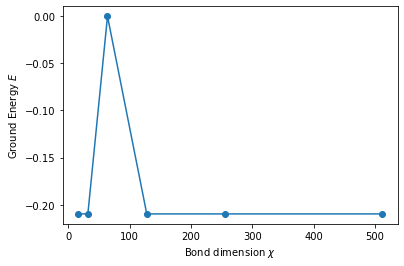

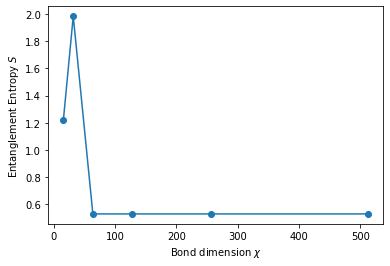

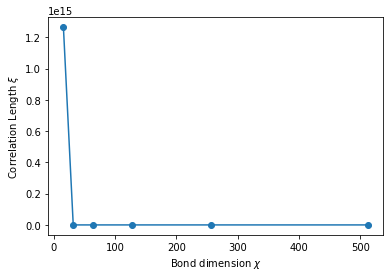

In [8]:
plot_results(data)

In [9]:
run(calc_correlation=False)

parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=2 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=1.0 for KitaevLadderModel
parameter 'Jz'=1.0 for KitaevLadderModel


==============================START==============================
Chi =  16 

parameter 'verbose'=1.0 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
..........
parameter 'max_sweeps'=150 for DMRG
parameter 'max_E_err'=1e-10 for DMRG
parameter 'max_S_err'=1e-06 for DMRG
parameter 'mixer'=False for Sweep
Updating environment
.....
sweep 10, age = 408
Energy = -0.2097005542639829, S = 1.2231352291255340, norm_err = 9.9e-14
Current memory usage 224.4 MB, time elapsed: 3.9 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 7.8871e-07, max_E_trunc = 1.3231e-06
MPS bond dimensions: [16, 16, 16, 16, 16, 16, 16, 16]
Updating environm

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2252: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2273: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (-1.7458223982920306e-05+7.45918700791478e-06j)
After the canonicalization:
Bond dim =  [16, 18, 16, 17, 15, 18, 17, 19]
Computing properties
Optimizing
Loop for chi=32 done.
============================== END ==============================


==============================START==============================
Chi =  64 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 408
Energy = -0.0002359173184291, S = 0.5300860500247906, norm_err = 7.8e-15
Current memory usage 228.3 MB, time elapsed: 4.7 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 7.1062e-19, max_E_trunc = 8.3267e-17
MPS bond dimensions: [48, 64, 48, 64, 48, 64, 48, 64]
Updating environment
.....
sweep 20, age = 648
Energy = -0.0002359173184291, S = 0.5300860500247988, norm_err = 3.3e-15
Current memory usage 228.3 MB, time elapsed: 8.9 s
Delta E = -3.4694e-19, Delta S = 8.2157e-16 (per sweep)
max_trunc_err = 7.6872e-19, max_E_trunc = 1.6653

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2252: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2096: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2273: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (0.9999999999999996-4.85722573273506e-16j)
After the canonicalization:
Bond dim =  [28, 38, 28, 38, 28, 38, 28, 38]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================


==============================START==============================
Chi =  128 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 408
Energy = -0.2097012464827763, S = 0.5300860500247870, norm_err = 3.3e-15
Current memory usage 228.3 MB, time elapsed: 4.0 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 6.5397e-20, max_E_trunc = 8.5265e-14
MPS bond dimensions: [49, 66, 49, 66, 49, 66, 49, 66]
Updating environment
.....
sweep 20, age = 648
Energy = -0.2097012464827586, S = 0.5300860500247929, norm_err = 1.8e-15
Current memory usage 228.3 MB, time elapsed: 8.1 s
Delta E = 1.7764e-15, Delta S = 5.8842e-16 (per sweep)
max_trunc_err = 6.7157e-20, max_E_trunc = 1.4211e-13


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2252: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2096: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2273: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000000000049+3.9876955904016853e-16j)
After the canonicalization:
Bond dim =  [28, 38, 28, 38, 28, 38, 28, 38]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================


==============================START==============================
Chi =  256 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 408
Energy = -0.2097012464827683, S = 0.5300860500247907, norm_err = 2.9e-15
Current memory usage 228.3 MB, time elapsed: 4.3 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 6.7157e-20, max_E_trunc = 9.9476e-14
MPS bond dimensions: [49, 66, 49, 66, 49, 66, 49, 66]
Updating environment
.....
sweep 20, age = 648
Energy = -0.2097012464828047, S = 0.5300860500247943, norm_err = 2.8e-15
Current memory usage 228.3 MB, time elapsed: 8.4 s
Delta E = -3.6415e-15, Delta S = 3.5527e-16 (per sweep)
max_trunc_err = 6.7157e-20, max_E_trunc = 1.5632e

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2252: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2096: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2273: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (0.9999999999999998-4.510281037539698e-16j)
After the canonicalization:
Bond dim =  [27, 38, 28, 38, 26, 38, 29, 38]
Computing properties
Optimizing
Loop for chi=256 done.
============================== END ==============================


==============================START==============================
Chi =  512 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 408
Energy = -0.2097012464827612, S = 0.5300860500247897, norm_err = 2.3e-15
Current memory usage 228.3 MB, time elapsed: 4.5 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 6.7157e-20, max_E_trunc = 7.1054e-14
MPS bond dimensions: [49, 66, 49, 66, 49, 66, 49, 66]
Updating environment
.....
sweep 20, age = 648
Energy = -0.2097012464828012, S = 0.5300860500247992, norm_err = 2.5e-15
Current memory usage 228.3 MB, time elapsed: 8.8 s
Delta E = -3.9968e-15, Delta S = 9.5479e-16 (per sweep)
max_trunc_err = 6.7157e-20, max_E_trunc = 9.9476e-

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2252: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2096: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2273: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


{'chi_list': [16, 32, 64, 128, 256, 512],
 'energy_list': [-0.20970055358782425,
  -0.20970124627830522,
  -0.00023591731842912637,
  -0.20970124648275856,
  -0.20970124648280475,
  -0.2097012464828012],
 'entropy_list': [1.2231369626140505,
  1.9832833894433528,
  0.5300860500247292,
  0.5300860500247176,
  0.5300860500246894,
  0.5300860500246969],
 'correlation_list': []}

In [10]:
from scipy.optimize import curve_fit

def func(xi, c, a):
    return (c / 6) * np.log(xi) + a

In [11]:
xi = correlation_list
log_xi = np.log(correlation_list)
s = entropy_list
fitParams, fitCovariances = curve_fit(func, xi, s)

NameError: name 'correlation_list' is not defined

In [ ]:
fitCovariances

In [ ]:
2**4

In [ ]:
type(2**4)